In [1]:
import pandas as pd
import numpy as np
from util import read_plumed_file
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from scipy import stats

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects
import matplotlib.font_manager as font_manager

from msmbuilder.decomposition import tICA
from msmbuilder.msm import MarkovStateModel
from msmtools.analysis.dense.pcca import pcca

import pyemma.plots as mplt
import pyemma.msm as pymsm

file_home='path/to/directory/'

/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
def tica_transform(
    df_list, 
    cvs, 
    lag_time=1,  # ns
    n_components=5,
    timestep=0.002,  # ns
    start_time=100,  # ns
    end_time=250,  # ns
    return_tica=False,
):
    start_time = 1000 * start_time  # convert from ns to ps
    end_time = 1000 * end_time  # convert from ns to ps
    
    # convert to number of steps to be used for tICA
    lag_time_steps = int(lag_time / timestep)
    
    ref = pd.concat(
        [df.loc[start_time:end_time, cvs] for df in df_list],
        ignore_index=True
    )

    scaler = StandardScaler()
    scaler.fit(ref.values)
    X = [scaler.transform(df.loc[start_time:end_time, cvs].values) for df in df_list]
    
    tica = tICA(n_components=n_components, lag_time=lag_time_steps)
    tica.fit(X)

    tica.summarize()
    if return_tica:
        return tica.transform(X), tica, scaler
    return tica.transform(X)

/miniconda3/envs/py36/lib/python3.6/site-packages/pyemma/__init__.py:92: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.7, you have 2.5.6.
  .format(latest=latest, current=current), category=UserWarning)


# Read in Data

In [3]:
iso_colvars = [
    read_plumed_file(f'../uremic_toxins/protein_bound/indoxyl_sulfate/unbiased/COLVAR.{idx}') for idx in range(1, 16)
]

### Get CVS

In [4]:
cvs_of_interest = np.append(iso_colvars[0].columns[0:-3:2],
                            iso_colvars[0].columns[-3:])
iso = pd.concat(
            [df.loc[50000:250000, cvs_of_interest] for df in iso_colvars],
            ignore_index=True
    )

In [5]:
#from hyperparameter optimization
best_n=(2, 0.005, 50)

### Run tICA  

In [6]:
# using best hyperparams
transformed_tica, tica, scaler = tica_transform(
    iso_colvars, 
    cvs_of_interest, 
    lag_time=best_n[1],
    timestep=0.002,
    n_components=best_n[0],
    start_time=50, 
    end_time=250, 
    return_tica=True,
)

In [7]:
no_scale_dfs = []
for df in iso_colvars:
    copy = df[cvs_of_interest].copy()
    copy['tica1'] = np.sum(copy[cvs_of_interest] * tica.components_[0], axis=1)
    copy['tica2'] = np.sum(copy[cvs_of_interest] * tica.components_[1], axis=1)
    no_scale_dfs.append(copy)

tica_corr = []
for idx, df in enumerate(iso_colvars):
    df.loc[50000:, 'tica1'] = transformed_tica[idx][:, 0]
    df.loc[50000:, 'tica2'] = transformed_tica[idx][:, 1]
    tica_corr.append(df.loc[50000:, :].corr())
    
correlations = [[], []]

for idx, df in enumerate(tica_corr):
    for j in range(len(tica.timescales_)):
        correlations[j].append(df.corr()[f'tica{j + 1}'])
        
for idx, df in enumerate(iso_colvars):
    df.loc[50000:, 'tica1'] = transformed_tica[idx][:, 0]
    df.loc[50000:, 'tica2'] = transformed_tica[idx][:, 1]
    
all_tica = np.row_stack(transformed_tica)
hist, x_edges, y_edges = np.histogram2d(all_tica[:, 0], all_tica[:, 1], bins=100, normed=True)


# checkout tica projections with unscaled data (for iMetaD)

In [8]:
fig, axs = plt.subplots(3, 5,sharey=True,sharex=True, figsize = (30, 15))
cm = plt.cm.get_cmap('RdYlBu')
xlabels = ['50','100','150','200','250']
ylabels = ['0','0.2','0.4','0.6','0.8','1']
for idx, colvar in enumerate(transformed_tica):
    if idx < 5:
        r = 0
    elif idx < 10:
        r = 1
    else:
        r = 2
    scatters = axs[r,idx%5].scatter(
            colvar[::100, 0],
            colvar[::100, 1],
            c=np.arange(len(colvar[::100, 0])),
            alpha=0.5,
            cmap='RdYlBu'
        )
    contours = axs[r,idx%5].contour(
            x_edges[:-1], 
            y_edges[:-1], 
            hist.T, 
            levels=np.linspace(0.0, 0.01, 6),
            cmap=cm,
            zorder=0,
        )
    if idx%5 == 0: 
        axs[r,idx%5].set_ylabel('IC2', size=35)
        axs[r,idx%5].set_yticks(np.arange(-2, 5, step=2))
        axs[r,idx%5].tick_params(labelleft=True,length=5,labelsize=30) 
    else:
        axs[r,idx%5].set_yticks(np.arange(-2, 5, step=2))
        axs[r,idx%5].tick_params(labelleft=False,length=5,labelsize=30)  
    if idx >= 10:
        axs[r,idx%5].set_xlabel('IC2', size=35)
        axs[r,idx%5].set_xticks(np.arange(-2, 5, step=2))
        axs[r,idx%5].tick_params(labelbottom=True,length=5,labelsize=30)
    else:
        axs[r,idx%5].set_xticks(np.arange(-2, 5, step=2))        
        axs[r,idx%5].tick_params(labelbottom=False,length=5) 
#right color bar (prob)       
fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.83, 0.12, 0.01, .76])
cbar = fig.colorbar(contours, ax=axs[:,idx%5], cax=cbar_ax)
cbar.ax.set_yticklabels(ylabels, size=30)
cbar.ax.set_ylabel('prob', size=30)
#lower color bar (time)
lcbar_ax = fig.add_axes([0.125, 0.02, 0.7, .01])
cbar2 = fig.colorbar(scatters, ax=axs[r,:], cax=lcbar_ax,orientation='horizontal',)
cbar2.ax.locator_params(nbins=4)
cbar2.ax.set_xticklabels(xlabels, size=30)
cbar2.ax.set_xlabel('time (ns)', size=30)

#plt.savefig(file_home+'iso_tica_densities.png', 
#           dpi=300, bbox_inches='tight')

Text(0.5, 0, 'time (ns)')

# cluster w/ minibatchkmeans

In [9]:
clusterer = MiniBatchKMeans(n_clusters=best_n[2], random_state=10)
clusterer.fit(np.row_stack(transformed_tica))

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=50,
        n_init=3, random_state=10, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [10]:
tica_cluster_dfs = []

for idx, traj in enumerate(transformed_tica):
    df = pd.DataFrame(
        traj, 
        index=iso_colvars[0].loc[50000:, :].index, 
        columns=['tica1', 'tica2'],
    )
    df['clust_id'] = clusterer.predict(df.values)
    tica_cluster_dfs.append(df)

Text(0.5, 0, 'k-means Cluster label')

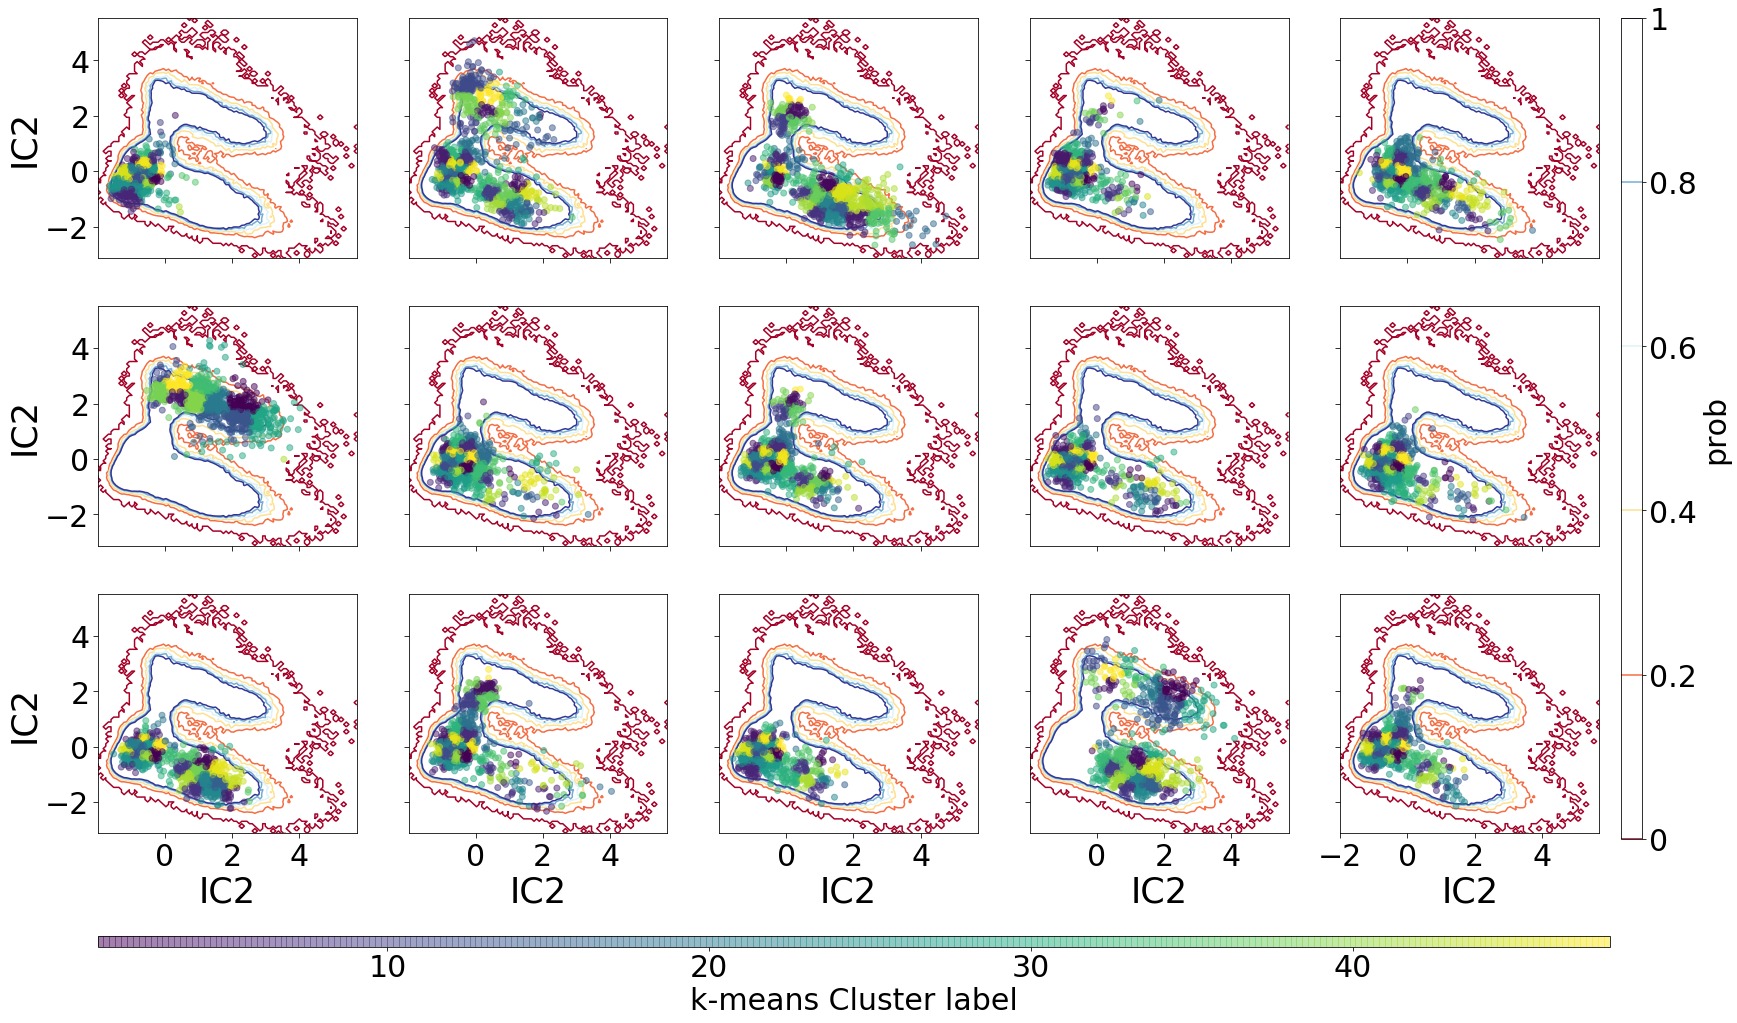

In [11]:
fig, axs = plt.subplots(3, 5,sharey=True,sharex=True, figsize = (30, 15))
cm = plt.cm.get_cmap('RdYlBu')
xlabels = ['10','20','30','40']
ylabels = ['0','0.2','0.4','0.6','0.8','1']
for idx, colvar in enumerate(tica_cluster_dfs):
    if idx < 5:
        r = 0
    elif idx < 10:
        r = 1
    else:
        r = 2
    scatters = axs[r,idx%5].scatter(
        colvar.loc[::100, 'tica1'],
        colvar.loc[::100, 'tica2'],
        c=colvar.loc[::100, 'clust_id'],
        alpha=0.5,
        cmap='viridis'
    )
    contours = axs[r,idx%5].contour(
            x_edges[:-1], 
            y_edges[:-1], 
            hist.T, 
            levels=np.linspace(0.0, 0.01, 6),
            cmap=cm,
            zorder=0,
        )
    if idx%5 == 0: 
        axs[r,idx%5].set_ylabel('IC2', size=35)
        axs[r,idx%5].set_yticks(np.arange(-2, 5, step=2))
        axs[r,idx%5].tick_params(labelleft=True,length=5,labelsize=30) 
    else:
        axs[r,idx%5].set_yticks(np.arange(-2, 5, step=2))
        axs[r,idx%5].tick_params(labelleft=False,length=5,labelsize=30)  
    if idx >= 10:
        axs[r,idx%5].set_xlabel('IC2', size=35)
        axs[r,idx%5].set_xticks(np.arange(-2, 5, step=2))
        axs[r,idx%5].tick_params(labelbottom=True,length=5,labelsize=30)
    else:
        axs[r,idx%5].set_xticks(np.arange(-2, 5, step=2))        
        axs[r,idx%5].tick_params(labelbottom=False,length=5) 
#right color bar (prob)       
fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.83, 0.12, 0.01, .76])
cbar = fig.colorbar(contours, ax=axs[:,idx%5], cax=cbar_ax)
cbar.ax.set_yticklabels(ylabels, size=30)
cbar.ax.set_ylabel('prob', size=30)
#lower color bar (time)
lcbar_ax = fig.add_axes([0.125, 0.02, 0.7, .01])
cbar2 = fig.colorbar(scatters, ax=axs[r,:], cax=lcbar_ax,orientation='horizontal',)
cbar2.ax.set_xticklabels(xlabels,size=30)
cbar2.ax.set_xlabel('k-means Cluster label', size=30)

#plt.savefig(file_home+'iso_kmeans_clusters.png', 
#            dpi=300, bbox_inches='tight')

# Checking parameters

In [33]:
plt.figure(figsize=(6, 4.5))

fullclust = pd.concat(
        [df.loc[:,'clust_id'] for df in tica_cluster_dfs],
        #ignore_index=True
)

lags=[1e1,5e1,1e2,2e2,5e2,9e2]
lagsns=np.asarray(lags)*0.002
msm_list = [
    MarkovStateModel(lag_time=x, n_timescales=25, verbose=False)
                     for x in lags
]
ar=[]
for n,msm in enumerate(msm_list):
    msm.fit(fullclust.values)
    ar.append(msm.timescales_)

for n,i in enumerate(np.transpose(ar)):
    plt.plot(np.asanyarray(lags)*0.002,i*0.002,
             #label=f'Lag time: {lagsns[n]} ns',
             color='b',
             #alpha=a
            )
plt.plot([500*0.002,500*0.002], [0, 2000], ls='--', color='k', alpha=0.3)
plt.ylim(0.01,100)
plt.ylabel('Timescale (ns)',fontsize=15)
plt.xlabel('Lag Time (ns)',fontsize=15)
plt.yscale('log')
#plt.legend()
#plt.savefig('iso_its.png', dpi=300, bbox_inches='tight')

print(f'biggest gap = {np.transpose(ar)[0][-1]-np.transpose(ar)[1][-1]:0.0f} ns')


biggest gap = 8529 ns


In [38]:
#test MSM setup
msm = MarkovStateModel(n_timescales=4, lag_time=500, reversible_type='transpose', verbose=False)
msm.fit([df.loc[:,'clust_id'] for df in tica_cluster_dfs])
print(msm.timescales_*0.002)

[ 20.819   7.056   3.083   1.493]


/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


First Relaxation time from MSM: 2.08E+01 ns
First Relaxation time from tICA: 8.55E-02 ns


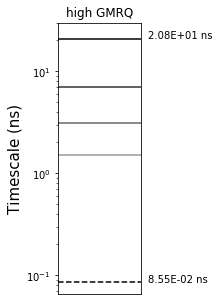

In [39]:
#also find the lowest score and plot those to compare
#make sure that we are in fact increasing the lower bound
#of the longest (first) timescale
dt = 0.002
tab_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

plt.figure(figsize=(1.5, 5))
for idx, timescale in enumerate(msm.timescales_):
    alpha = 1 - idx*0.2
    #print(alpha)
    plt.plot([0, 1], [timescale * dt, timescale * dt], color='k', alpha=alpha) # color=tab_colors[idx])
    
for idx, timescale in enumerate(tica.timescales_[:1]):
    plt.plot([0, 1], [timescale * dt, timescale * dt], color='k', ls='--')  #tab_colors[idx], alpha=0.5, ls='--')
plt.text(1.08, msm.timescales_[0] * dt,f'{msm.timescales_[0] * 0.002:0.02E} ns', color='k')
plt.text(1.08, tica.timescales_[0] * dt,f'{tica.timescales_[0] * 0.002:0.02E} ns', color='k')
    
plt.yscale('log')
plt.ylabel('Timescale (ns)',fontsize = 15)
plt.ylim(0, 30)
plt.xlim(0, 1)
plt.title('high GMRQ')
plt.xticks([], [])
print(f'First Relaxation time from MSM: {msm.timescales_[0] * 0.002:0.02E} ns')
#print(tica.timescales_*0.002)
print(f'First Relaxation time from tICA: {tica.timescales_[0] * 0.002:0.02E} ns')



# Build MSM

In [34]:
msm = MarkovStateModel(n_timescales=4, lag_time=500, reversible_type='transpose', verbose=False)
msm.fit([df.loc[:,'clust_id'] for df in tica_cluster_dfs])
print(msm.timescales_*0.002)

[ 20.819   7.056   3.083   1.493]


In [15]:
n_states = 3
# calculate coarse macrostates from msm transition matrix
coarse_msm = pcca(msm.transmat_, n_states)
cluster_map = coarse_msm.argmax(axis=1)
# add macrostate id to tica_cluster_dfs
for df in tica_cluster_dfs:
    df['macro_state'] = cluster_map[df['clust_id']]
# calculate macrostate transition matrix
macro_transmat = np.zeros([n_states, n_states])
for i in range(n_states):
    for j in range(n_states):
        ij_transmat = msm.transmat_[np.where(cluster_map == i)][:, np.where(cluster_map == j)]
        macro_transmat[i, j] = ij_transmat.sum() / len(ij_transmat)
        
all_traj_clust = pd.concat(tica_cluster_dfs, ignore_index=True)
all_clusts = [all_traj_clust]

In [16]:
# calculate the overall center (mean) of all point in each cluster
macro_centers = [
    pd.concat([
        df[df['macro_state'] == state_id][['tica1', 'tica2']] for df in tica_cluster_dfs
    ]).mean()
    for state_id in range(macro_transmat.shape[0])
]

# set colors for later 
all_traj_clust = pd.concat(tica_cluster_dfs, ignore_index=True)
all_clusts = [all_traj_clust]
colors = plt.cm.get_cmap('viridis', n_states)
restates=['0','1','2']

Text(0, 0.5, 'prob')

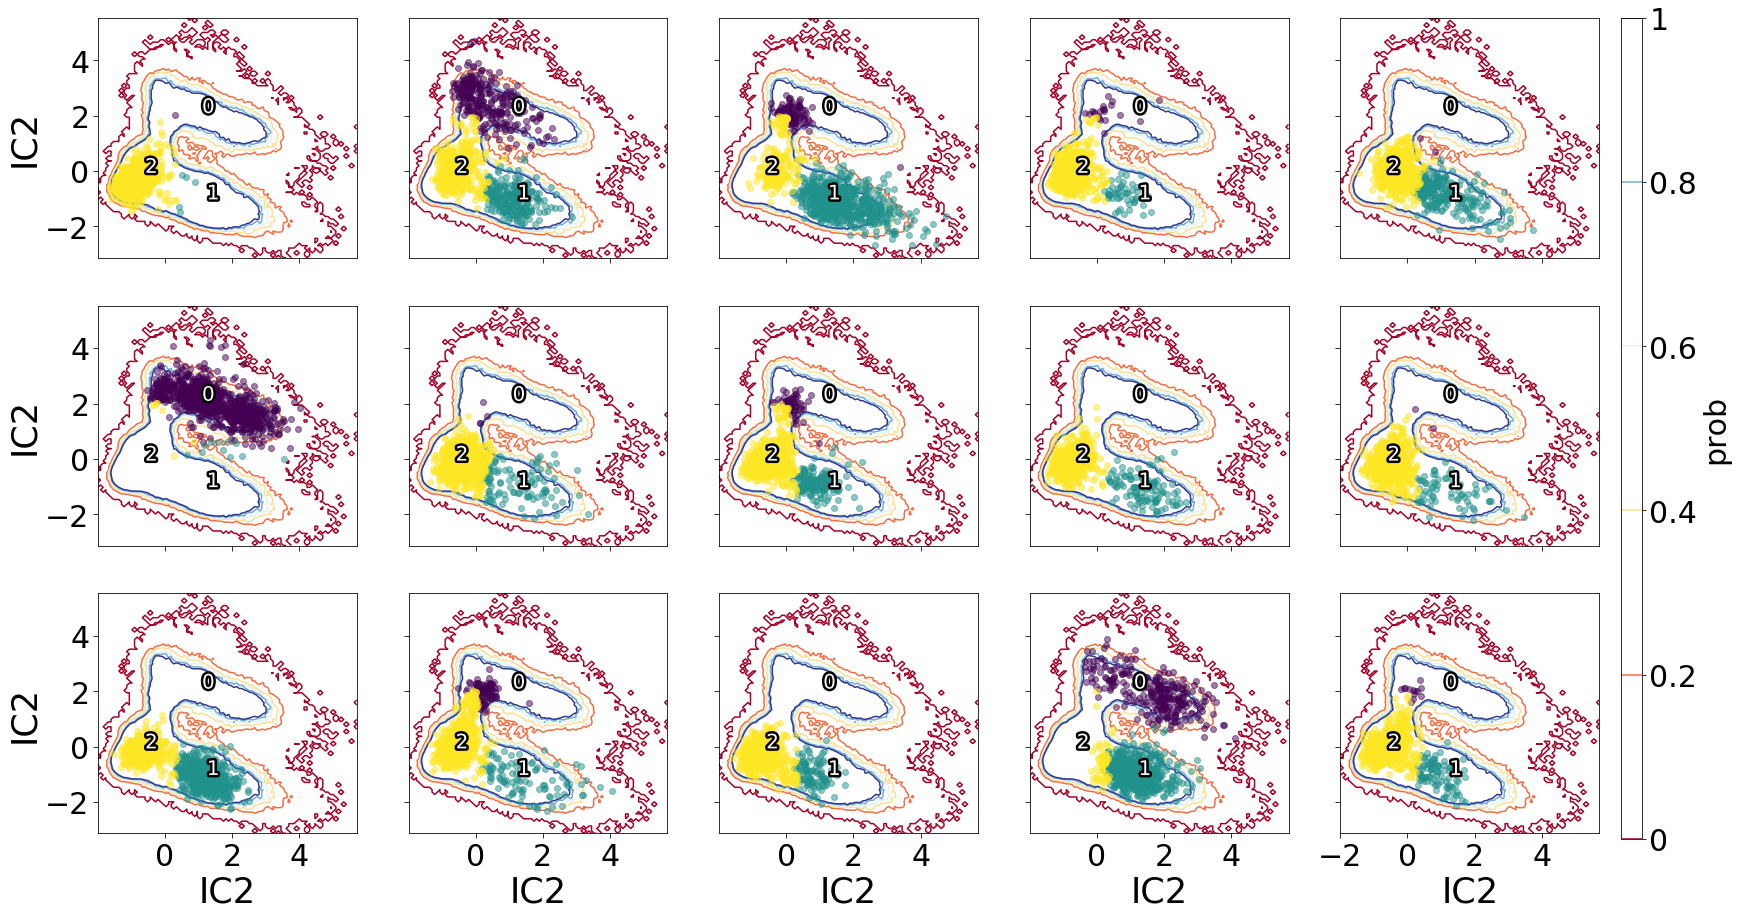

In [17]:
fig, axs = plt.subplots(3, 5,sharey=True,sharex=True, figsize = (30, 15))
ylabels = ['0','0.2','0.4','0.6','0.8','1']
font0 = font_manager.FontProperties()
font0.set_size('large')
for idx, colvar in enumerate(tica_cluster_dfs):
    if idx < 5:
        r = 0
    elif idx < 10:
        r = 1
    else:
        r = 2
    colvar = colvar.loc[::100, :]
    for state_id in range(macro_transmat.shape[0]):
        colvar_id = colvar[colvar['macro_state'] == state_id]
        scatters = axs[r,idx%5].scatter(
            colvar_id['tica1'],
            colvar_id['tica2'],
            color=colors(state_id),
            alpha=0.5,
            label=f'{state_id}'
            #cmap='viridis'
        )
        txt=axs[r,idx%5].text(
                macro_centers[state_id]['tica1'], 
                macro_centers[state_id]['tica2'],
                s=restates[state_id],
                color='w',
                size=20
            )
        txt.set_path_effects([patheffects.withStroke(
            linewidth=5, foreground='k')])
    contours = axs[r,idx%5].contour(
            x_edges[:-1], 
            y_edges[:-1], 
            hist.T, 
            levels=np.linspace(0.0, 0.01, 6),
            cmap=cm,
            zorder=0,
        )
    if idx%5 == 0: 
        axs[r,idx%5].set_ylabel('IC2', size=35)
        axs[r,idx%5].set_yticks(np.arange(-2, 5, step=2))
        axs[r,idx%5].tick_params(labelleft=True,length=5,labelsize=30) 
    else:
        axs[r,idx%5].set_yticks(np.arange(-2, 5, step=2))
        axs[r,idx%5].tick_params(labelleft=False,length=5,labelsize=30)  
    if idx >= 10:
        axs[r,idx%5].set_xlabel('IC2', size=35)
        axs[r,idx%5].set_xticks(np.arange(-2, 5, step=2))
        axs[r,idx%5].tick_params(labelbottom=True,length=5,labelsize=30)
    else:
        axs[r,idx%5].set_xticks(np.arange(-2, 5, step=2))        
        axs[r,idx%5].tick_params(labelbottom=False,length=5) 
#right color bar (prob)       
fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.83, 0.12, 0.01, .76])
cbar = fig.colorbar(contours, ax=axs[:,idx%5], cax=cbar_ax)
cbar.ax.set_yticklabels(ylabels, size=30)
cbar.ax.set_ylabel('prob', size=30)
#plt.savefig(file_home+'iso_msm_clusters.png', 
#            dpi=300, bbox_inches='tight')


In [18]:
all_traj_clust = pd.concat(tica_cluster_dfs, ignore_index=True)
all_clusts = [all_traj_clust]
colvar = all_clusts[0].loc[::50, :]
assignments = msm.partial_transform(clusterer.labels_)

Text(0, 0.5, 'Transition Progress')

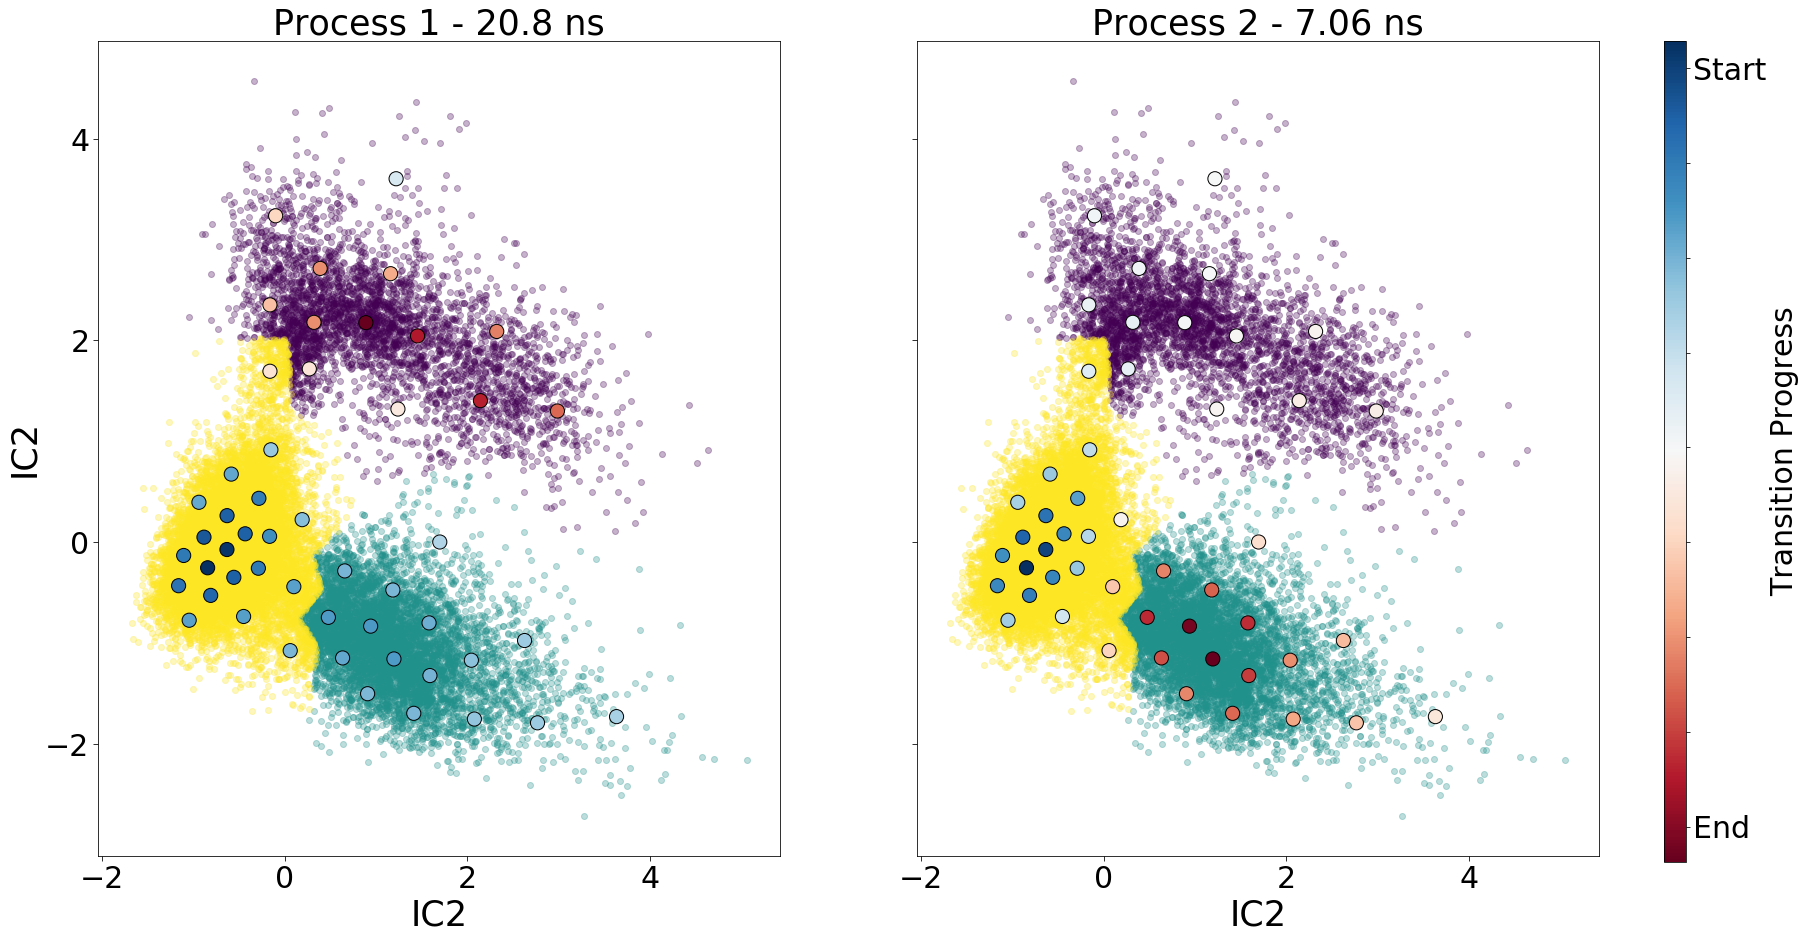

In [21]:
fig, axs = plt.subplots(1, 2,sharey=True,sharex=True, figsize = (30,15))
ylabels = ['End','','','','','','','','Start']
for idx, col in enumerate(msm.left_eigenvectors_.T[1:3]):
    for state_id in range(macro_transmat.shape[0]):
        colvar_id = colvar[colvar['macro_state'] == state_id]
        scatters = axs[idx].scatter(
            colvar_id['tica1'],
            colvar_id['tica2'],
            color=colors(state_id),
            alpha=0.3,
            label=f'{state_id}'
        )
    egvs = axs[idx].scatter(clusterer.cluster_centers_[msm.state_labels_, 0],
                clusterer.cluster_centers_[msm.state_labels_, 1],
                #s=1e4 * msm.populations_,# size by population
                s=200,
                c=col,# color by eigenvector
                edgecolors='k',
                cmap="RdBu",
                zorder=3) 
    if idx == 0: 
        axs[idx].set_ylabel('IC2', size=35)
        axs[idx].set_yticks(np.arange(-2, 5, step=2))
        axs[idx].tick_params(labelleft=True,length=5,labelsize=30) 
    else:
        axs[idx].set_yticks(np.arange(-2, 5, step=2))
        axs[idx].tick_params(labelleft=False,length=5,labelsize=30)   
    axs[idx].set_xlabel('IC2', size=35)
    axs[idx].set_xticks(np.arange(-2, 5, step=2))
    axs[idx].tick_params(labelbottom=True,length=5,labelsize=30)
    axs[idx].set_title(f'Process {idx+1} - {msm.timescales_[idx]*0.002:0.03} ns',size=35)

#right color bar (prob)       
fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.85, 0.12, 0.01, .76])
cbar = fig.colorbar(egvs, ax=axs[idx], cax=cbar_ax)
#cbar.ax.locator_params(nbins=2)
cbar.ax.set_yticklabels(ylabels, size=30)
cbar.ax.set_ylabel('Transition Progress', size=30)
#plt.savefig(file_home+'iso_2eigenvectors.png', 
#           dpi=300, bbox_inches='tight')

Text(0, 0.5, 'Left Eigenvector 2')

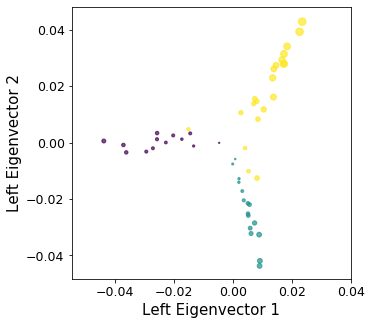

In [20]:
d={'left Eigenvector 1':msm.left_eigenvectors_[:,1],
   'left Eigenvector 2':msm.left_eigenvectors_[:,2],
   'macro_state':cluster_map,
   'pop':msm.populations_}
temp=pd.DataFrame(data=d)

plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)
colors = plt.cm.get_cmap('viridis', n_states)
for state_id in range(macro_transmat.shape[0]):
    colvar_id = temp[temp['macro_state'] == state_id]
    ax.scatter(
            colvar_id['left Eigenvector 1'],
            colvar_id['left Eigenvector 2'],
            color=colors(state_id),
            alpha=0.7,
            label=f'{state_id}',
            s=colvar_id['pop']*1e3
        )

plt.xticks(fontsize=12.5)
plt.yticks(fontsize=12.5)
#plt.xlim(min(temp['left Eigenvector 1']),
 #        max(temp['left Eigenvector 1']))
#plt.ylim(min(temp['left Eigenvector 2']),
#         max(temp['left Eigenvector 2']))
#plt.xlim(-0.025,0.041)
plt.xticks(np.arange(-0.04, 0.06, step=0.02) )
plt.xlabel('Left Eigenvector 1', size = 15)
plt.ylabel('Left Eigenvector 2', size = 15)
#plt.savefig('new_is_kineticmap_small.png', dpi=300, bbox_inches='tight')

In [134]:
#new run 9, 3 node IS
for i in range(macro_transmat.shape[0]):
    yellow_center = np.square(
        all_traj_clust[['tica1', 'tica2']] - macro_centers[i]
    ).sum(axis=1).idxmin()
    sim_id = int(np.floor(yellow_center / tica_cluster_dfs[0].shape[0]))
    time = tica_cluster_dfs[sim_id].index[yellow_center - sim_id * tica_cluster_dfs[0].shape[0]]
    print(f'cluster {i} center: simulation {sim_id + 1}, {time} ps')
    
    filename=f'../uremic_toxins/protein_bound/indoxyl_sulfate/unbiased/unb_frame_{sim_id + 1}_{i}.ndx'
    
    w = open(filename,'w')
    w.write(f'[frames] \n {str(time/2.+1)} \n')
    w.close()

cluster 0 center: simulation 6, 153330.0 ps
cluster 1 center: simulation 11, 170274.0 ps
cluster 2 center: simulation 9, 210010.0 ps


# check implied timescales and important descriptors

In [22]:
# calculate projection onto the first n_timescales dynamical vectors
msm_mode_projections = msm.eigtransform(
    [df['clust_id'].values for df in tica_cluster_dfs]
)

In [23]:
corr_df = []
for idx, colvar in enumerate(iso_colvars):
    df = colvar.loc[50000:, cvs_of_interest]
    df['msm_eig1'] = msm_mode_projections[idx][:, 0]
    df['msm_eig2'] = msm_mode_projections[idx][:, 1]
    df['msm_eig3'] = msm_mode_projections[idx][:, 2]
    df['msm_eig4'] = msm_mode_projections[idx][:, 3]
    
    corr_df.append(df)

In [24]:
correlations = [[], [], [], []]

for idx, df in enumerate(corr_df):
    for j in range(len(msm.timescales_)):
        correlations[j].append(df.corr()[f'msm_eig{j + 1}'])


In [25]:
cemma=[]
for i in range(0,n_states):
    cemma.append(colors(i))
#cemma[0]=cemma[0]+0.1
P = macro_transmat
M = pymsm.markov_model(P)

mplt.plot_markov_model(M, pos=np.asanyarray(macro_centers),
                       state_colors=cemma,
                       arrow_labels=None,
                       color='white',
                       size=20
                      );
#([patheffects.withStroke(linewidth=5, foreground='k')])
#plt.savefig(file_home+'is_tpt.png', 
#            dpi=300, bbox_inches='tight')

In [26]:
P = macro_transmat
M = pymsm.markov_model(P)
M.stationary_distribution

array([ 0.22150816,  0.28296722,  0.49552461])

In [27]:
np.set_printoptions(precision=3)
M.transition_matrix

array([[ 0.916,  0.013,  0.071],
       [ 0.011,  0.872,  0.117],
       [ 0.031,  0.067,  0.901]])

In [28]:
pd.concat(correlations[2], axis=1).mean(axis=1).sort_values(ascending=False)[1:]

msm_eig1         0.563362
K410_com_dist    0.410555
Y407_com_dist    0.301093
S485_com_dist    0.287396
msm_eig2         0.165844
msm_eig4         0.153063
R406_com_dist    0.118828
h1_h2           -0.023287
L383_com_dist   -0.034053
h1_h3           -0.055885
h2_h3           -0.065544
N387_com_dist   -0.209548
L449_com_dist   -0.336712
L426_com_dist   -0.364721
V429_com_dist   -0.378660
dtype: float64

In [29]:
pd.concat(correlations[1], axis=1).mean(axis=1).sort_values(ascending=False)

msm_eig2         1.000000
N387_com_dist    0.295085
V429_com_dist    0.285927
msm_eig4         0.267713
L426_com_dist    0.238301
msm_eig3         0.165844
L383_com_dist    0.125310
L449_com_dist    0.061741
h1_h3            0.028497
msm_eig1        -0.074212
S485_com_dist   -0.098678
K410_com_dist   -0.183055
h1_h2           -0.223038
h2_h3           -0.252782
Y407_com_dist   -0.340300
R406_com_dist   -0.838440
dtype: float64

In [30]:
pd.concat(correlations[2], axis=1).mean(axis=1).sort_values(ascending=False)

msm_eig3         1.000000
msm_eig1         0.563362
K410_com_dist    0.410555
Y407_com_dist    0.301093
S485_com_dist    0.287396
msm_eig2         0.165844
msm_eig4         0.153063
R406_com_dist    0.118828
h1_h2           -0.023287
L383_com_dist   -0.034053
h1_h3           -0.055885
h2_h3           -0.065544
N387_com_dist   -0.209548
L449_com_dist   -0.336712
L426_com_dist   -0.364721
V429_com_dist   -0.378660
dtype: float64

In [31]:
pd.concat(correlations[3], axis=1).mean(axis=1).sort_values(ascending=False)

msm_eig4         1.000000
msm_eig2         0.267713
msm_eig3         0.153063
N387_com_dist    0.152723
K410_com_dist    0.079384
L383_com_dist    0.054383
Y407_com_dist    0.053376
msm_eig1         0.036763
h1_h3            0.033418
V429_com_dist    0.018588
L426_com_dist    0.010695
S485_com_dist    0.007059
L449_com_dist   -0.024419
h1_h2           -0.035169
h2_h3           -0.084783
R406_com_dist   -0.106583
dtype: float64

In [32]:
all_traj_corr = pd.concat(corr_df, ignore_index=True)